# Accelerated Alternating Projection

Paper: https://arxiv.org/pdf/1711.05519.pdf

Matlab Script: https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/AccAltProj.m

Full Repository: https://github.com/caesarcai/AccAltProj_for_RPCA 

In [1]:
import numpy as np
from numpy import linalg as LA
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
import math
import scipy.stats as stats

from helper import *

torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
def thres(inputs, t, hard=True, old=True):
    if not hard:
        out = torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape))
    else:
        if old:
            out = inputs * (torch.abs(inputs) > t)
        else:
            # out = torch.sign(inputs) * torch.max(\
            #                                     torch.abs(inputs) - torch.nan_to_num(torch.div(torch.pow(t, 6), torch.pow(torch.abs(inputs), 5))) \
            #                                     , torch.zeros(inputs.shape))
            # out = torch.sign(inputs) * torch.max(torch.abs(inputs) \
            #                                     - torch.div(t, torch.exp(3 * torch.div(torch.abs(inputs) - t, t))) \
            #                                     , torch.zeros(inputs.shape))
            # out = inputs * torch.max(1 - torch.div(torch.pow(t, 2), torch.pow(inputs, 2)), torch.zeros(inputs.shape))
            # out = torch.div(1,  1 + torch.exp(-100 * (torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape))))) \
            #         + torch.sign(inputs) * torch.max(torch.abs(inputs)- t, torch.zeros(inputs.shape)) \
            #         - t
            # mu = 1.0005 * t
            # out = inputs * (torch.abs(inputs) >= mu) \
            #         + torch.sign(inputs) * (mu/(mu-t))*(torch.abs(inputs) - t) * (mu > torch.abs(inputs)) * (torch.abs(inputs) >= t)
            gamma, beta = 0.95, 1
            out = inputs * (torch.abs(inputs) > torch.sqrt(gamma * beta * t**2)) * (beta <= gamma) \
                    + torch.sign(inputs) * torch.min(beta/(beta - gamma) * torch.max(torch.abs(inputs) - (t * gamma), torch.zeros(inputs.shape)), torch.abs(inputs)) * (beta > gamma)
    return out

## Unrolled version

In [3]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

class InitStage(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, M0, r):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        beta = 1/(2 * np.power(m * n, 1/4))
        beta_init = 4 * beta
        zeta = beta_init * torch.linalg.norm(M0, 2)
        S = thres(M0, zeta, hard=True, old=False)
        U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
        U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
        L = U @ torch.diag(Sigma) @ V.t()
        zeta = beta * Sigma[0]
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V, beta, norm_of_M0

class ProjStage(nn.Module):
    def __init__(self, gamma, lay):
        super().__init__()
        self.gamma = gamma
        self.lay = lay
    def forward(self, M0, S, U, V, r, beta):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sm, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sm[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sm[r] + torch.pow(self.gamma, self.lay) * Sm[0])
        S = M0 - L
        S = thres(S, zeta, hard=True, old=False)
        return S, L, U, V

class LearnedAAP(nn.Module):
    def __init__(self, max_iter, d1, d2):
        super().__init__()
        self.max_iter = max_iter
        self.gamma = nn.Parameter(torch.tensor(0.7))
        #self.gamma = torch.tensor(0.7)
        self.beta = nn.Parameter(torch.tensor(1/(2 * np.power(d1 * d2, 1/4))))

        ## Stack layers
        self.layer = [InitStage()]
        for t in range(max_iter):
            #self.layer.append(ProjStage(gamma = nn.Parameter(torch.pow(self.gamma.clone().detach(), t + 1).requires_grad_(True))))
            #self.layer.append(ProjStage(gamma = nn.Parameter(self.gamma.clone().detach().requires_grad_(True))))
            self.layer.append(ProjStage(self.gamma, t+1))
        self.layers = nn.Sequential(*self.layer)
        ## Track loss
        self.err = np.zeros(max_iter + 1)

    def forward(self, M0, r):
        lay_init = self.layers[0]
        S, L, U, V, beta, norm_of_M0 = lay_init(M0, r)
        for t in range(1, self.max_iter + 1):
            lay = self.layers[t]
            S, L, U, V = lay(M0, S, U, V, r, self.beta)
            self.err[t] = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        return L, S

## The Pipeline

### Scenario 1:
**alpha = 0.1** (low sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=7.579e-01; beta=7.070e-02

***results: only relative err increased (from 0 to <5e-07 which is also very good) whereas the other errors got reduced***

In [4]:
## ======================== 0. set constants ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 50              # num. of layers trained
alpha_true = 0.1
c_true = 1
r = 2
dataset_size = 300

## ======================== 1. generate data ========================
train, test =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [5]:
## ======================== 2. estimations by classical ========================
## ======================== USING IRCUR AS EST ========================
train_est = []
for i, (L_true, S_true, M_true) in enumerate(train):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est.append((L0, S0, M_true))

In [6]:
## ======================== 3. train unrolled network with estimated data ========================
net, params_bftrain, params_aftrain, l0_norm_of_S_Shat = train_nn(LearnedAAP(max_iter, d1, d2), r \
                                                                    , lr=2e-02, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est)

[Parameter containing:
tensor(7.005e-01, requires_grad=True), Parameter containing:
tensor(3.184e-02, dtype=torch.float64, requires_grad=True)]
tensor(-2.317e-10) tensor(-1.074e-10, dtype=torch.float64)
Epoch 1/8 at cost=3.013195248868783e-11
[Parameter containing:
tensor(7.029e-01, requires_grad=True), Parameter containing:
tensor(3.314e-02, dtype=torch.float64, requires_grad=True)]
tensor(-2.520e-09) tensor(-1.256e-09, dtype=torch.float64)
Epoch 1/8 at cost=4.690316884881085e-11
[Parameter containing:
tensor(7.046e-01, requires_grad=True), Parameter containing:
tensor(3.402e-02, dtype=torch.float64, requires_grad=True)]
tensor(-1.422e-10) tensor(-6.478e-11, dtype=torch.float64)
Epoch 1/8 at cost=2.424277271984021e-11
[Parameter containing:
tensor(7.061e-01, requires_grad=True), Parameter containing:
tensor(3.479e-02, dtype=torch.float64, requires_grad=True)]
tensor(-5.699e-10) tensor(-2.475e-10, dtype=torch.float64)
Epoch 1/8 at cost=4.9485120862113874e-11
[Parameter containing:
tens

#### Evaluating unrolled network on train dataset

In [7]:
out_bftrain, out_hat = get_net_outputs(net, LearnedAAP(max_iter, d1, d2), r, train)
out_accaltproj = []
for i, (L_true, S_true, M_true) in enumerate(train):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


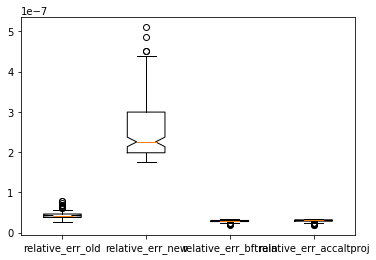

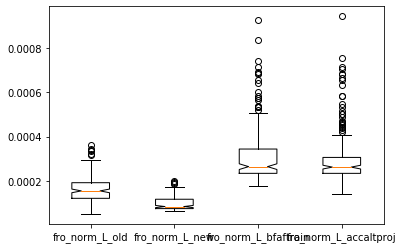

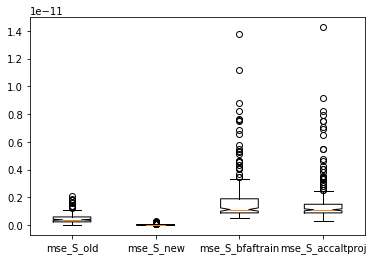

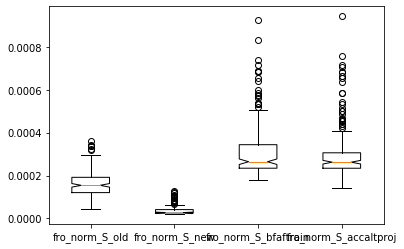

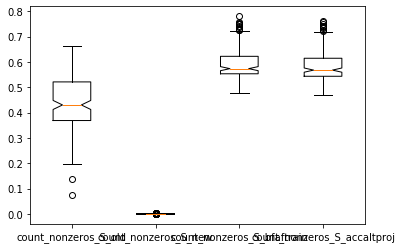

In [8]:
metrics = get_metrics(train, [x[:2] for x in train_est], out_bftrain, out_hat)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train, out_accaltproj, out_bftrain, out_hat).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [9]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  4.4401353819121776e-26
mse_S_new, mse_S_old:  5.309938053312097e-36
fro_norm_S_new, fro_norm_S_old:  5.80470984523235e-61
count_nonzeros_S_new, count_nonzeros_S_old:  8.84189565248632e-114

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  1.6751951318767435e-53
mse_S_new, mse_S_accaltproj:  2.3268578832908487e-26
fro_norm_S_new, fro_norm_S_accaltproj:  5.320388805463491e-70
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.562135143845227e-179

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  1.9222524172665958e-52
mse_S_new, mse_S_bftrain:  5.930920340593231e-27
fro_norm_S_new, fro_norm_S_bftrain:  3.3840199224494404e-68
count_nonzeros_S_new, count_nonzeros_S_bftrain:  4.689568249949753e-178


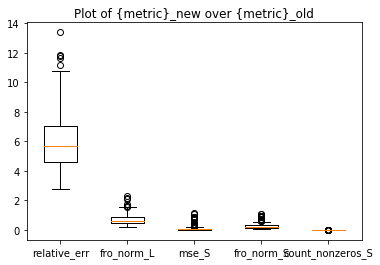

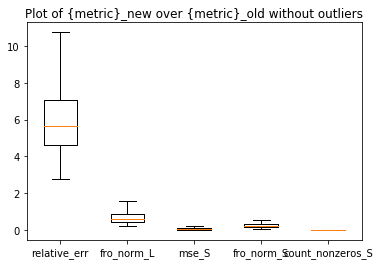

relative_err: 5/180 outliers
fro_norm_L: 7/180 outliers
mse_S: 24/180 outliers
fro_norm_S: 14/180 outliers
count_nonzeros_S: 38/180 outliers


In [10]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [11]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  1.0
fro_norm_L:  4.562641754009425e-21
mse_S:  3.225867172373329e-119
fro_norm_S:  6.2669565352083745e-105
count_nonzeros_S:  0.0


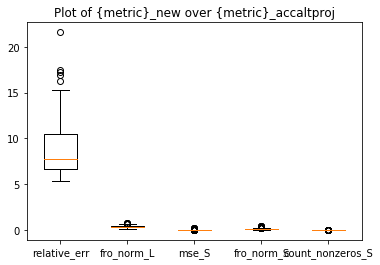

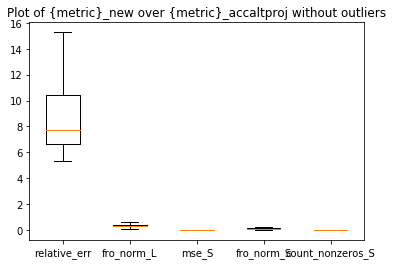

relative_err: 5/180 outliers
fro_norm_L: 7/180 outliers
mse_S: 26/180 outliers
fro_norm_S: 22/180 outliers
count_nonzeros_S: 40/180 outliers


In [12]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [13]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  8.270251810664943e-128
mse_S:  1.466156429743305e-262
fro_norm_S:  4.7195952592078924e-191
count_nonzeros_S:  0.0


#### Evaluating unrolled network on test dataset

In [14]:
out_bftrain_ontest, out_hat_ontest = get_net_outputs(net, LearnedAAP(max_iter, d1, d2), r, test)
out_accaltproj_ontest = []
out_ircur_ontest = []
for (L_true, S_true, M_true) in test:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


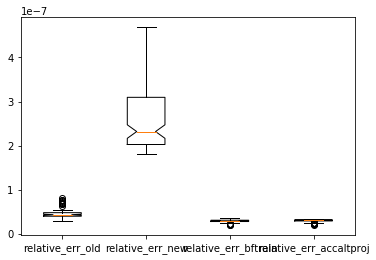

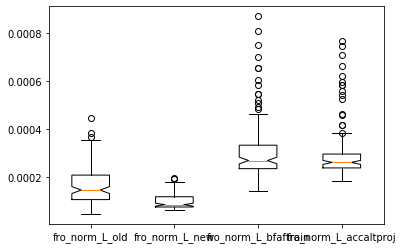

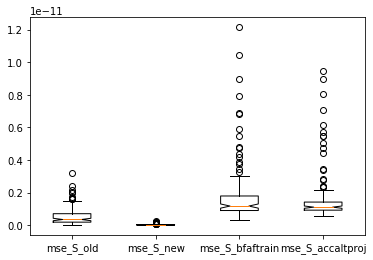

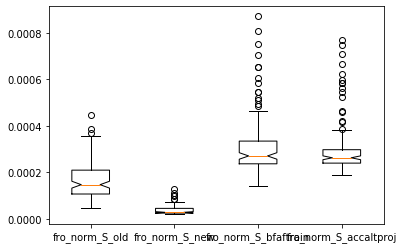

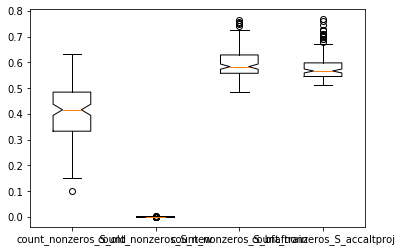

In [15]:
metrics = get_metrics(test, out_ircur_ontest, out_bftrain_ontest, out_hat_ontest)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test, out_accaltproj_ontest, out_bftrain_ontest, out_hat_ontest).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [16]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  1.1105641983976084e-15
mse_S_new, mse_S_old:  1.0563169166699062e-18
fro_norm_S_new, fro_norm_S_old:  2.9783106017725784e-35
count_nonzeros_S_new, count_nonzeros_S_old:  1.4806919661726472e-73

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  5.736093836608862e-37
mse_S_new, mse_S_accaltproj:  4.5561605502144385e-20
fro_norm_S_new, fro_norm_S_accaltproj:  4.199676049407219e-49
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.2013309412417052e-121

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  5.304554942296635e-35
mse_S_new, mse_S_bftrain:  1.665359027654767e-18
fro_norm_S_new, fro_norm_S_bftrain:  3.883255567851904e-46
count_nonzeros_S_new, count_nonzeros_S_bftrain:  9.613090525358022e-123


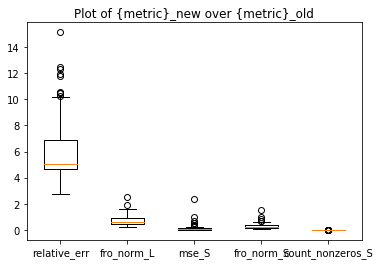

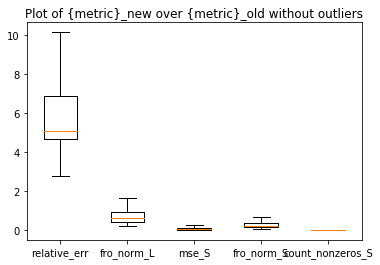

relative_err: 9/120 outliers
fro_norm_L: 2/120 outliers
mse_S: 9/120 outliers
fro_norm_S: 5/120 outliers
count_nonzeros_S: 26/120 outliers


In [17]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err, \
     "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [18]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  1.0
fro_norm_L:  3.0439901687056616e-12
mse_S:  4.578108073683334e-70
fro_norm_S:  2.0176113411819355e-70
count_nonzeros_S:  0.0


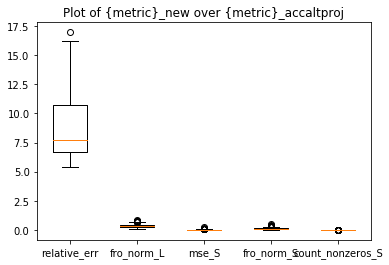

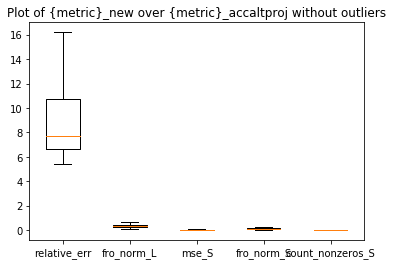

relative_err: 1/120 outliers
fro_norm_L: 8/120 outliers
mse_S: 18/120 outliers
fro_norm_S: 12/120 outliers
count_nonzeros_S: 24/120 outliers


In [19]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err, \
     "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [20]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  3.4997131680607854e-77
mse_S:  4.524166352212249e-172
fro_norm_S:  3.817852668286269e-125
count_nonzeros_S:  0.0


In [21]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj))

0.0 0.00019626667
0.566488 0.5853098


### Scenario 2:
**alpha = 0.3** (higher sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=7.433e-01,; beta=5.649e-02

In [22]:
## ======================== 0. set constants ========================
#d1 = 250                   # num. of rows
#d2 = 250                   # num. of columns
#max_iter = 100              # num. of layers trained
alpha_true = 0.3
c_true = 1
#r = 2
#dataset_size = 300

## ======================== 1. generate data ========================
train2, test2 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [23]:
## ======================== 2. estimations by classical ========================
train_est2 = []
for i, (L_true, S_true, M_true) in enumerate(train2):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est2.append((L0, S0, M_true))

In [24]:
## ======================== 3. train unrolled network with estimated data ========================
net2, params_bftrain2, params_aftrain2, l0_norm_of_S_Shat2 = train_nn(LearnedAAP(max_iter, d1, d2), r \
                                                                    , lr=2e-02, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est2)

[Parameter containing:
tensor(7.015e-01, requires_grad=True), Parameter containing:
tensor(3.258e-02, dtype=torch.float64, requires_grad=True)]
tensor(-7.827e-10) tensor(-5.008e-10, dtype=torch.float64)
Epoch 1/8 at cost=3.489594724292999e-11
[Parameter containing:
tensor(7.028e-01, requires_grad=True), Parameter containing:
tensor(3.334e-02, dtype=torch.float64, requires_grad=True)]
tensor(-6.616e-10) tensor(-3.075e-10, dtype=torch.float64)
Epoch 1/8 at cost=1.2685556598224235e-11
[Parameter containing:
tensor(7.038e-01, requires_grad=True), Parameter containing:
tensor(3.389e-02, dtype=torch.float64, requires_grad=True)]
tensor(-1.707e-10) tensor(-8.610e-11, dtype=torch.float64)
Epoch 1/8 at cost=3.1838649772186756e-11
[Parameter containing:
tensor(7.047e-01, requires_grad=True), Parameter containing:
tensor(3.440e-02, dtype=torch.float64, requires_grad=True)]
tensor(-4.563e-10) tensor(-2.166e-10, dtype=torch.float64)
Epoch 1/8 at cost=1.5974031125631782e-11
[Parameter containing:
te

#### Evaluating unrolled network on train dataset

In [25]:
out_bftrain2, out_hat2 = get_net_outputs(net2, LearnedAAP(max_iter, d1, d2), r, train2)
out_accaltproj2 = []
for i, (L_true, S_true, M_true) in enumerate(train2):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj2.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


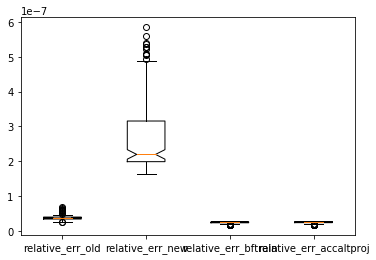

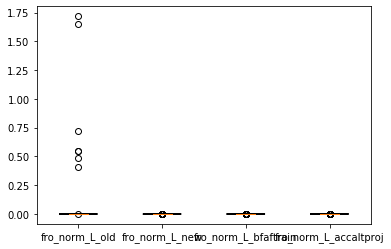

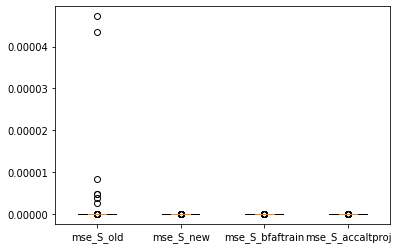

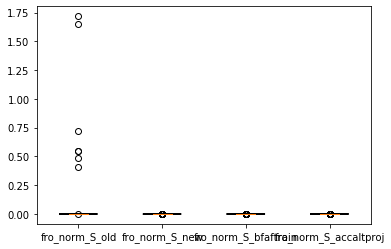

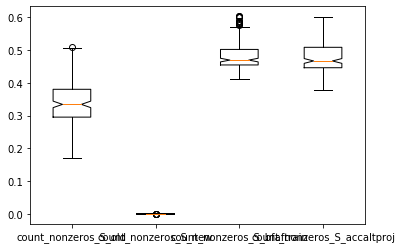

In [26]:
metrics = get_metrics(train2, [x[:2] for x in train_est2], out_bftrain2, out_hat2)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train2, out_accaltproj2, out_bftrain2, out_hat2).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [27]:
print("P-values from test of mean with H1: _new < _old")
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

print("*Note: values are log-transformed before deriving p-values")
print()
print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
*Note: values are log-transformed before deriving p-values

relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  3.890861791442814e-08
mse_S_new, mse_S_old:  2.0108746773655114e-18
fro_norm_S_new, fro_norm_S_old:  2.0109250611115054e-18
count_nonzeros_S_new, count_nonzeros_S_old:  nan

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  2.9751033509933697e-75
mse_S_new, mse_S_accaltproj:  3.84451898468511e-104
fro_norm_S_new, fro_norm_S_accaltproj:  3.844072122866046e-104
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  nan

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  1.90794896079593e-72
mse_S_new, mse_S_bftrain:  2.173073822154497e-100
fro_norm_S_new, fro_norm_S_bftrain:  2.1727837796935017e-100
count_nonzeros_S_new, count_nonzeros_S_bftrain:  nan


/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_60049/2360404741.py:27: RuntimeWarning: divide by zero encountered in log
  print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_60049/2360404741.py:34: RuntimeWarning: divide by zero encountered in log
  print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
/var/folders/st/_q3p7lz50mncs1x1m22w92gc0000gn/T/ipykernel_60049/2360404741.py:40: RuntimeWarning: divide by zero encountered in log
  print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.

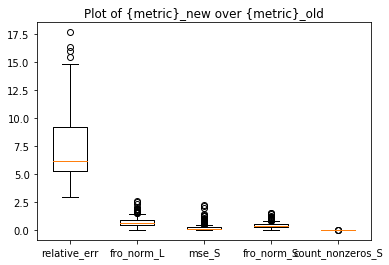

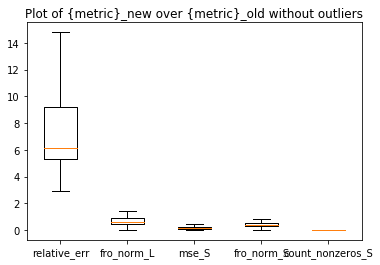

relative_err: 4/180 outliers
fro_norm_L: 16/180 outliers
mse_S: 28/180 outliers
fro_norm_S: 17/180 outliers
count_nonzeros_S: 3/180 outliers


In [28]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [29]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  1.0
fro_norm_L:  2.178286425721002e-12
mse_S:  9.184995533676449e-65
fro_norm_S:  1.0321400286194197e-66
count_nonzeros_S:  0.0


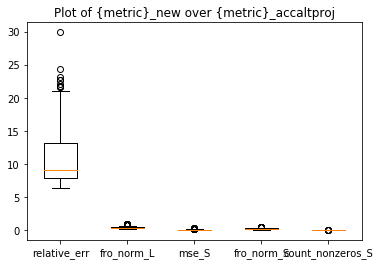

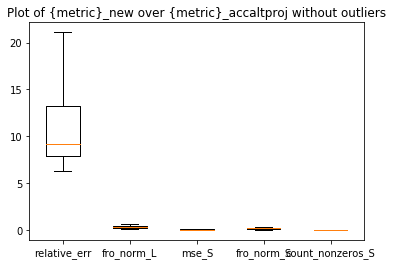

relative_err: 9/180 outliers
fro_norm_L: 15/180 outliers
mse_S: 22/180 outliers
fro_norm_S: 15/180 outliers
count_nonzeros_S: 5/180 outliers


In [30]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [31]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  1.0371003191316902e-105
mse_S:  3.360550608564163e-225
fro_norm_S:  1.9146453691320108e-164
count_nonzeros_S:  0.0


#### Evaluating unrolled network on test dataset

In [32]:
out_bftrain_ontest2, out_hat_ontest2 = get_net_outputs(net2, LearnedAAP(max_iter, d1, d2), r, test2)
out_accaltproj_ontest2 = []
out_ircur_ontest2 = []
for (L_true, S_true, M_true) in test2:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest2.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest2.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


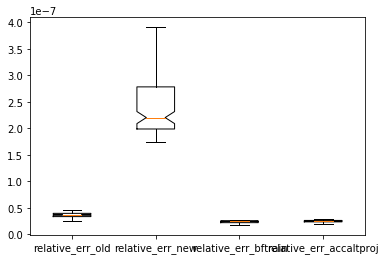

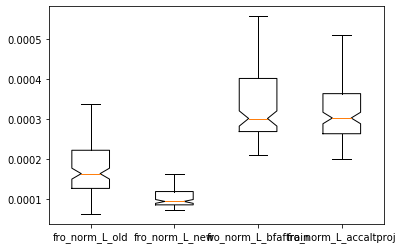

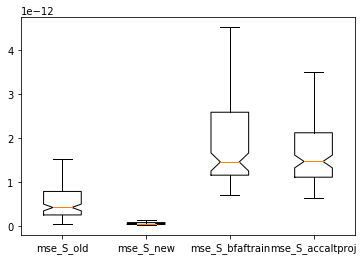

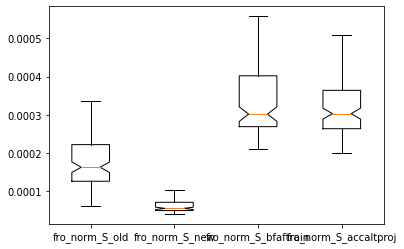

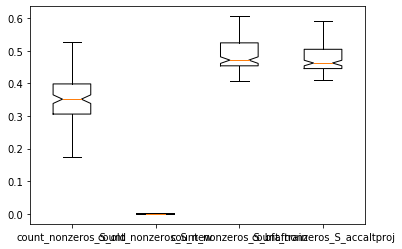

In [33]:
metrics = get_metrics(test2, out_ircur_ontest2, out_bftrain_ontest2, out_hat_ontest2)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test2, out_accaltproj_ontest2, out_bftrain_ontest2, out_hat_ontest2).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [34]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  0.0515964093453279
mse_S_new, mse_S_old:  0.07322080765627421
fro_norm_S_new, fro_norm_S_old:  0.05140684116598137
count_nonzeros_S_new, count_nonzeros_S_old:  3.2074413415945574e-78

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  6.0892332038832714e-33
mse_S_new, mse_S_accaltproj:  4.1233705014244235e-16
fro_norm_S_new, fro_norm_S_accaltproj:  2.4585457658334156e-40
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  6.159608595850656e-122

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  1.0110823965102567e-43
mse_S_new, mse_S_bftrain:  5.611053403162096e-23
fro_norm_S_new, fro_norm_S_bftrain:  3.4063104141248427e-51
count_nonzeros_S_new, count_nonzeros_S_bftrain:  3.872330481829728e-124


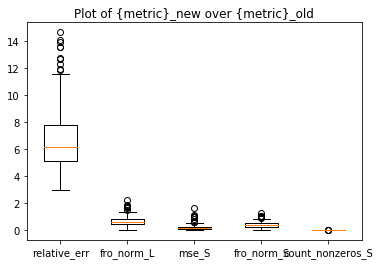

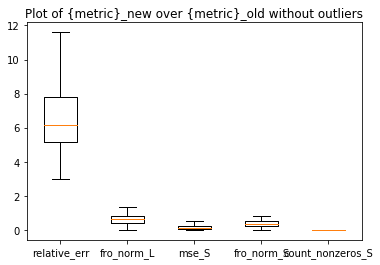

relative_err: 10/120 outliers
fro_norm_L: 8/120 outliers
mse_S: 12/120 outliers
fro_norm_S: 8/120 outliers
count_nonzeros_S: 3/120 outliers


In [35]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [36]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  1.0
fro_norm_L:  1.6314662926772295e-12
mse_S:  2.4931871965357506e-59
fro_norm_S:  4.084947563857908e-53
count_nonzeros_S:  0.0


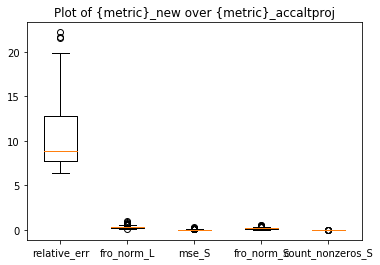

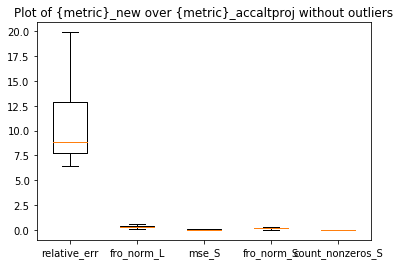

relative_err: 3/120 outliers
fro_norm_L: 15/120 outliers
mse_S: 17/120 outliers
fro_norm_S: 10/120 outliers
count_nonzeros_S: 5/120 outliers


In [37]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [38]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  3.952657177515961e-77
mse_S:  1.5921928704469022e-154
fro_norm_S:  2.9490015908992482e-115
count_nonzeros_S:  0.0


In [39]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj))

0.0 1.0933333e-05
0.462456 0.4783808


### Scenario 3:
**alpha = 0.01** (lower sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=7.195e-01; beta=1.112e-01

*** ***

In [40]:
## ======================== 0. set constants ========================
# d1 = 250                   # num. of rows
# d2 = 250                   # num. of columns
# max_iter = 100              # num. of layers trained
alpha_true = 0.01
c_true = 1
# r = 2
# dataset_size = 300

## ======================== 1. generate data ========================
train3, test3 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [41]:
## ======================== 2. estimations by classical ========================
train_est3 = []
for i, (L_true, S_true, M_true) in enumerate(train3):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est3.append((L0, S0, M_true))

In [42]:
## ======================== 3. train unrolled network with estimated data ========================
net3, params_bftrain3, params_aftrain3, l0_norm_of_S_Shat3 = train_nn(LearnedAAP(max_iter, d1, d2), r \
                                                                    , lr=2e-04, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est3)

[Parameter containing:
tensor(7.001e-01, requires_grad=True), Parameter containing:
tensor(3.167e-02, dtype=torch.float64, requires_grad=True)]
tensor(-5.890e-09) tensor(-3.037e-09, dtype=torch.float64)
Epoch 1/8 at cost=4.222536487130668e-10
[Parameter containing:
tensor(7.002e-01, requires_grad=True), Parameter containing:
tensor(3.175e-02, dtype=torch.float64, requires_grad=True)]
tensor(-2.480e-08) tensor(-1.263e-08, dtype=torch.float64)
Epoch 1/8 at cost=6.901916260737551e-10
[Parameter containing:
tensor(7.003e-01, requires_grad=True), Parameter containing:
tensor(3.185e-02, dtype=torch.float64, requires_grad=True)]
tensor(-2.488e-08) tensor(-1.242e-08, dtype=torch.float64)
Epoch 1/8 at cost=3.4910671575794083e-10
[Parameter containing:
tensor(7.004e-01, requires_grad=True), Parameter containing:
tensor(3.193e-02, dtype=torch.float64, requires_grad=True)]
tensor(-8.022e-09) tensor(-3.732e-09, dtype=torch.float64)
Epoch 1/8 at cost=2.1170271091719428e-10
[Parameter containing:
ten

#### Evaluating unrolled network on train dataset

In [43]:
out_bftrain3, out_hat3 = get_net_outputs(net3, LearnedAAP(max_iter, d1, d2), r, train3)
out_accaltproj3 = []
for i, (L_true, S_true, M_true) in enumerate(train3):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj3.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


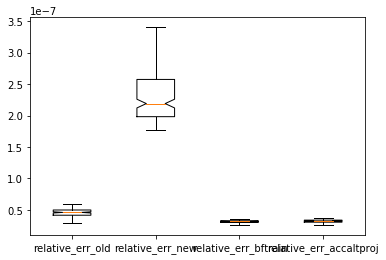

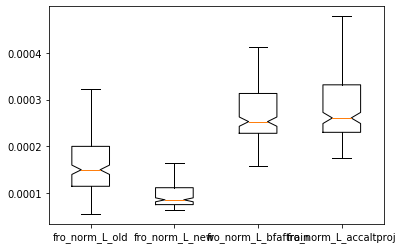

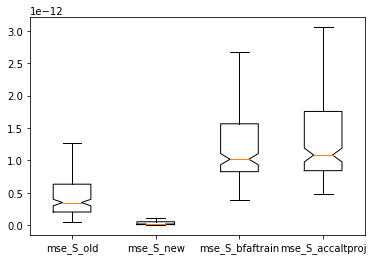

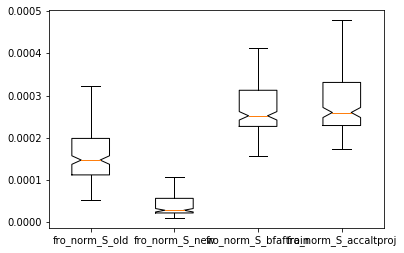

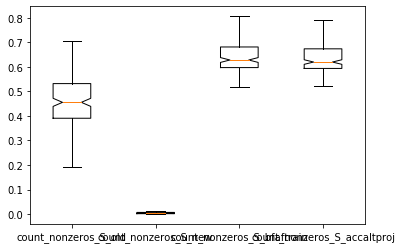

In [44]:
metrics = get_metrics(train3, [x[:2] for x in train_est3], out_bftrain3, out_hat3)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train3, out_accaltproj3, out_bftrain3, out_hat3).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [45]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  1.9905555705484585e-26
mse_S_new, mse_S_old:  6.890504149206157e-31
fro_norm_S_new, fro_norm_S_old:  2.186459634874018e-52
count_nonzeros_S_new, count_nonzeros_S_old:  6.064195689027655e-114

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  1.4555238514017243e-54
mse_S_new, mse_S_accaltproj:  1.198641366789708e-29
fro_norm_S_new, fro_norm_S_accaltproj:  1.3469281973034553e-67
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  3.2116244760252037e-174

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  7.555680120929322e-48
mse_S_new, mse_S_bftrain:  1.5811550565516073e-24
fro_norm_S_new, fro_norm_S_bftrain:  1.579109314543733e-60
count_nonzeros_S_new, count_nonzeros_S_bftrain:  2.2651880388149898e-174


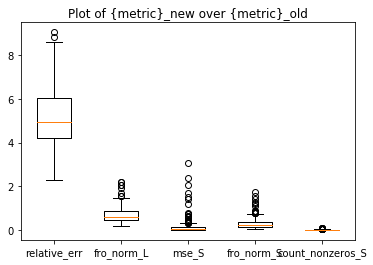

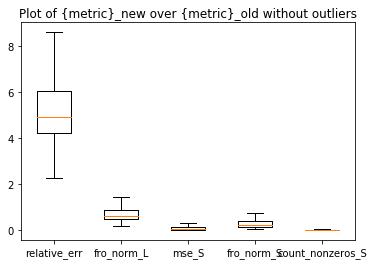

relative_err: 2/180 outliers
fro_norm_L: 8/180 outliers
mse_S: 26/180 outliers
fro_norm_S: 15/180 outliers
count_nonzeros_S: 17/180 outliers


In [46]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [47]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  1.0
fro_norm_L:  2.686127389189847e-22
mse_S:  1.0256307103081759e-66
fro_norm_S:  9.059075722519417e-77
count_nonzeros_S:  0.0


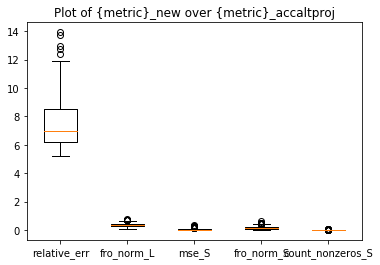

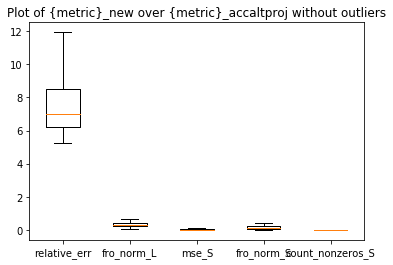

relative_err: 5/180 outliers
fro_norm_L: 8/180 outliers
mse_S: 18/180 outliers
fro_norm_S: 12/180 outliers
count_nonzeros_S: 15/180 outliers


In [48]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [49]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  3.690687918090125e-125
mse_S:  3.489231107436825e-216
fro_norm_S:  2.193495103934064e-155
count_nonzeros_S:  0.0


#### Evaluating unrolled network on test dataset

In [50]:
out_bftrain_ontest3, out_hat_ontest3 = get_net_outputs(net3, LearnedAAP(max_iter, d1, d2), r, test3)
out_accaltproj_ontest3 = []
out_ircur_ontest3 = []
for (L_true, S_true, M_true) in test3:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest3.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest3.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


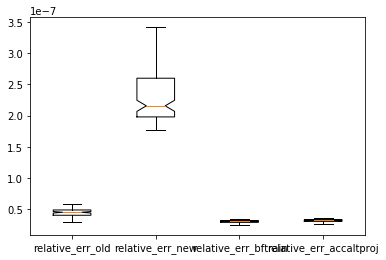

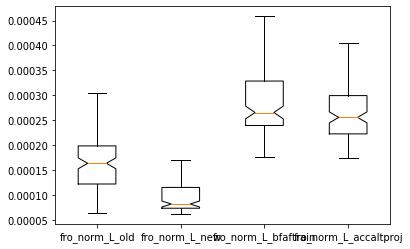

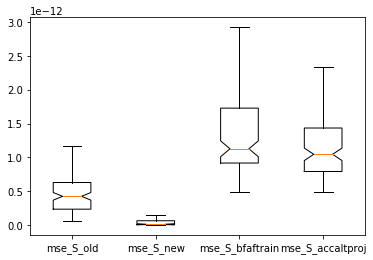

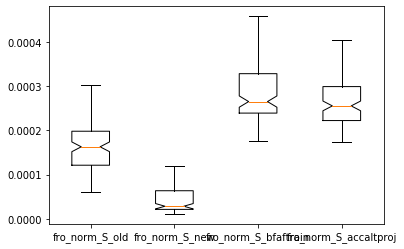

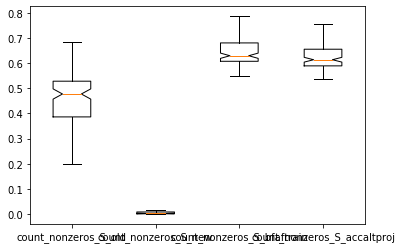

In [51]:
metrics = get_metrics(test3, out_ircur_ontest3, out_bftrain_ontest3, out_hat_ontest3)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test3, out_accaltproj_ontest3, out_bftrain_ontest3, out_hat_ontest3).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [52]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  5.199666343101745e-20
mse_S_new, mse_S_old:  2.0997842128910026e-21
fro_norm_S_new, fro_norm_S_old:  1.0711079190109898e-36
count_nonzeros_S_new, count_nonzeros_S_old:  3.2902259472188394e-82

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  1.506270946449901e-39
mse_S_new, mse_S_accaltproj:  2.3292000389843534e-22
fro_norm_S_new, fro_norm_S_accaltproj:  3.7306747714106686e-49
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  5.210661904953333e-123

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  1.8326391179885322e-37
mse_S_new, mse_S_bftrain:  1.2763543347439818e-20
fro_norm_S_new, fro_norm_S_bftrain:  3.132915893308017e-46
count_nonzeros_S_new, count_nonzeros_S_bftrain:  7.253356256231391e-119


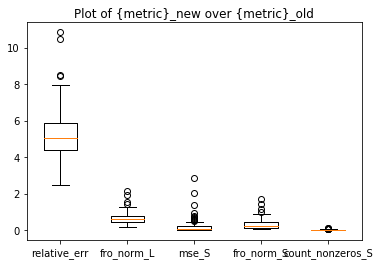

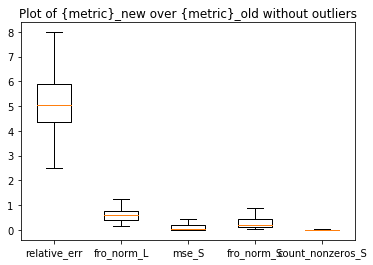

relative_err: 4/120 outliers
fro_norm_L: 4/120 outliers
mse_S: 11/120 outliers
fro_norm_S: 4/120 outliers
count_nonzeros_S: 8/120 outliers


In [53]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [54]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  1.0
fro_norm_L:  2.7105209047818193e-21
mse_S:  7.165914279901874e-49
fro_norm_S:  1.684048502114268e-53
count_nonzeros_S:  1.622577641789788e-203


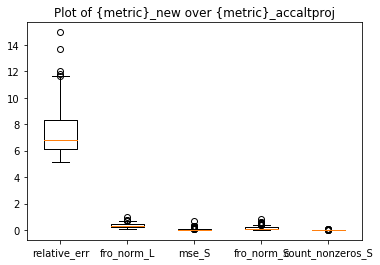

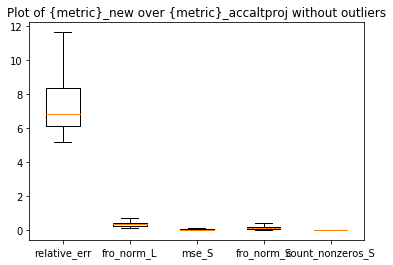

relative_err: 5/120 outliers
fro_norm_L: 4/120 outliers
mse_S: 20/120 outliers
fro_norm_S: 10/120 outliers
count_nonzeros_S: 8/120 outliers


In [55]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [56]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  1.4711095225903978e-77
mse_S:  3.0927432498315467e-124
fro_norm_S:  2.7584697921312097e-94
count_nonzeros_S:  1.4842031782745414e-227


In [57]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj))

0.0026 0.0061459998
0.613744 0.63147885


### Scenario 4:
**alpha = 0.1** (higher sparsity), **c = 10**, r = 2, dimension = 250x250

gamma=7.359e-01; beta=4.489e-02

*** ***

In [58]:
## ======================== 0. set constants ========================
# d1 = 250                   # num. of rows
# d2 = 250                   # num. of columns
# max_iter = 100              # num. of layers trained
alpha_true = 0.1
c_true = 10
# r = 2
# dataset_size = 300

## ======================== 1. generate data ========================
train4, test4 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 180
test dataset size: 120


#### Training

In [59]:
## ======================== 2. estimations by classical ========================
train_est4 = []
for i, (L_true, S_true, M_true) in enumerate(train4):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est4.append((L0, S0, M_true))

In [76]:
## ======================== 3. train unrolled network with estimated data ========================
net4, params_bftrain4, params_aftrain4, l0_norm_of_S_Shat4 = train_nn(LearnedAAP(max_iter, d1, d2), r \
                                                                    , lr=2e-02, weight_decay=0 \
                                                                    , nepochs=8, dataset=train_est4)

[Parameter containing:
tensor(7.001e-01, requires_grad=True), Parameter containing:
tensor(3.165e-02, dtype=torch.float64, requires_grad=True)]
tensor(-2.869e-11) tensor(-1.484e-11, dtype=torch.float64)
Epoch 1/8 at cost=2.658277894682093e-12
[Parameter containing:
tensor(7.001e-01, requires_grad=True), Parameter containing:
tensor(3.167e-02, dtype=torch.float64, requires_grad=True)]
tensor(-1.317e-11) tensor(-6.693e-12, dtype=torch.float64)
Epoch 1/8 at cost=1.3957543888026835e-12
[Parameter containing:
tensor(7.002e-01, requires_grad=True), Parameter containing:
tensor(3.171e-02, dtype=torch.float64, requires_grad=True)]
tensor(-6.039e-11) tensor(-3.009e-11, dtype=torch.float64)
Epoch 1/8 at cost=1.0346303891753394e-12
[Parameter containing:
tensor(7.002e-01, requires_grad=True), Parameter containing:
tensor(3.174e-02, dtype=torch.float64, requires_grad=True)]
tensor(-2.677e-11) tensor(-1.275e-11, dtype=torch.float64)
Epoch 1/8 at cost=8.752927853003523e-13
[Parameter containing:
ten

#### Evaluating unrolled network on train dataset

In [77]:
out_bftrain4, out_hat4 = get_net_outputs(net4, LearnedAAP(max_iter, d1, d2), r, train4)
out_accaltproj4 = []
for i, (L_true, S_true, M_true) in enumerate(train4):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj4.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


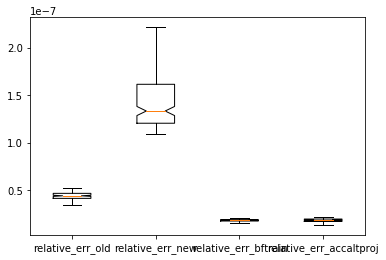

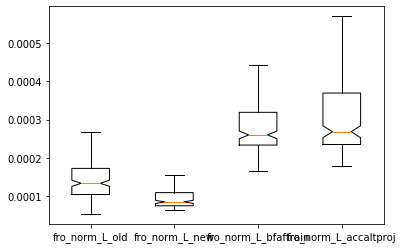

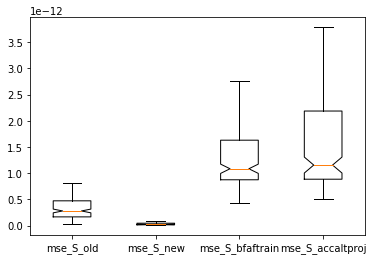

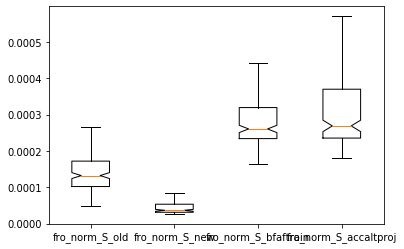

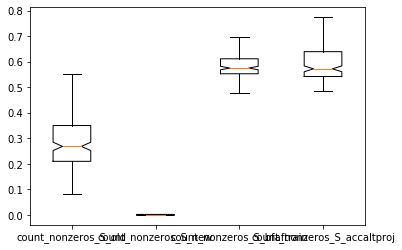

In [78]:
metrics = get_metrics(train4, [x[:2] for x in train_est4], out_bftrain4, out_hat4)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train4, out_accaltproj4, out_bftrain4, out_hat4).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, \
    relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", \
    "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [79]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  9.787157247150815e-19
mse_S_new, mse_S_old:  1.8370245604650328e-27
fro_norm_S_new, fro_norm_S_old:  1.0463195373488679e-46
count_nonzeros_S_new, count_nonzeros_S_old:  2.122588988455358e-86

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  1.6854399449764962e-49
mse_S_new, mse_S_accaltproj:  5.0827530158591414e-27
fro_norm_S_new, fro_norm_S_accaltproj:  8.317396832751538e-61
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  5.55433964782622e-167

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  5.6154208742655676e-55
mse_S_new, mse_S_bftrain:  5.385150725472701e-27
fro_norm_S_new, fro_norm_S_bftrain:  2.6438044430935557e-68
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.874259831090957e-185


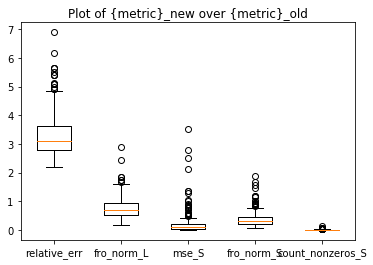

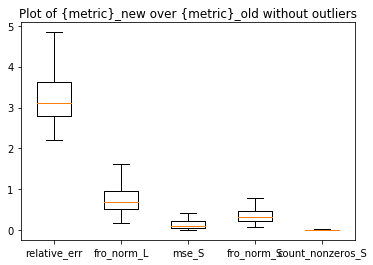

relative_err: 16/180 outliers
fro_norm_L: 7/180 outliers
mse_S: 24/180 outliers
fro_norm_S: 16/180 outliers
count_nonzeros_S: 20/180 outliers


In [80]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [81]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  1.0
fro_norm_L:  8.630071030084705e-13
mse_S:  8.009544910833772e-53
fro_norm_S:  4.875625840771141e-66
count_nonzeros_S:  4e-323


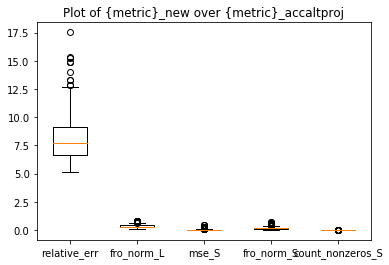

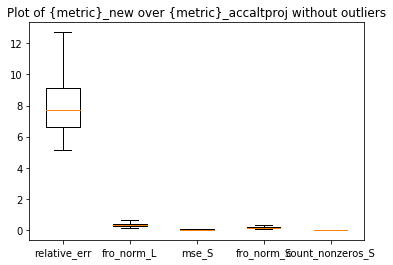

relative_err: 11/180 outliers
fro_norm_L: 12/180 outliers
mse_S: 27/180 outliers
fro_norm_S: 20/180 outliers
count_nonzeros_S: 26/180 outliers


In [82]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [83]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  1.017563976611747e-114
mse_S:  1.753673923080216e-201
fro_norm_S:  7.85740954637745e-152
count_nonzeros_S:  0.0


#### Evaluating unrolled network on test dataset

In [84]:
out_bftrain_ontest4, out_hat_ontest4 = get_net_outputs(net4, LearnedAAP(max_iter, d1, d2), r, test4)
out_accaltproj_ontest4 = []
out_ircur_ontest4 = []
for (L_true, S_true, M_true) in test4:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj_ontest4.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    out_ircur_ontest4.append((L0, S0))

/Users/elitanzc/Github/FYP/helper.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat1 = (torch.tensor(mat1) == 0)
/Users/elitanzc/Github/FYP/helper.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat2 = (torch.tensor(mat2) == 0)


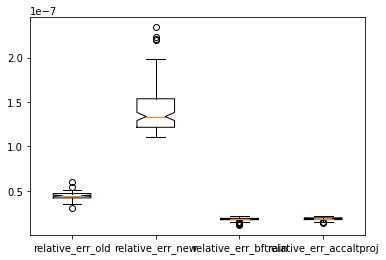

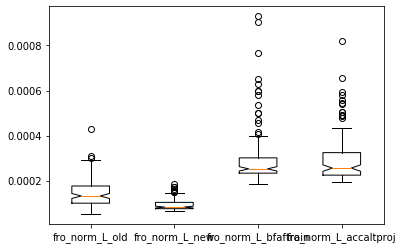

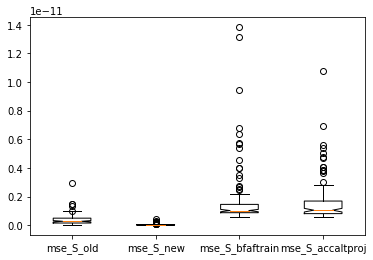

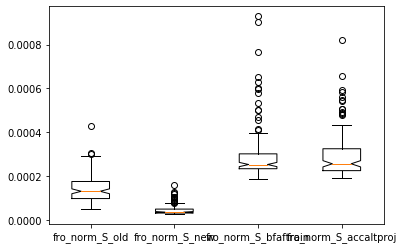

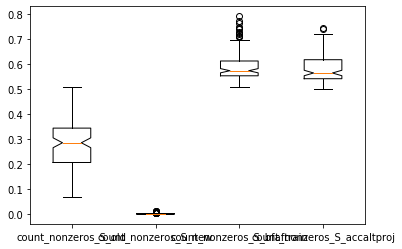

In [85]:
metrics = get_metrics(test4, out_ircur_ontest4, out_bftrain_ontest4, out_hat_ontest4)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test4, out_accaltproj_ontest4, out_bftrain_ontest4, out_hat_ontest4).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [86]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0
fro_norm_L_new, fro_norm_L_old:  2.462094064382668e-14
mse_S_new, mse_S_old:  1.549191215596396e-17
fro_norm_S_new, fro_norm_S_old:  3.381443013082024e-33
count_nonzeros_S_new, count_nonzeros_S_old:  6.257387689272079e-59

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.0
fro_norm_L_new, fro_norm_L_accaltproj:  7.967626862306805e-41
mse_S_new, mse_S_accaltproj:  7.718711382953238e-22
fro_norm_S_new, fro_norm_S_accaltproj:  3.9918594323804734e-50
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.6043204146442517e-122

relative_err_new, relative_err_bftrain:  1.0
fro_norm_L_new, fro_norm_L_bftrain:  2.015110683716044e-33
mse_S_new, mse_S_bftrain:  3.658401249454373e-15
fro_norm_S_new, fro_norm_S_bftrain:  5.3170984108003374e-42
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.7735312013252183e-119


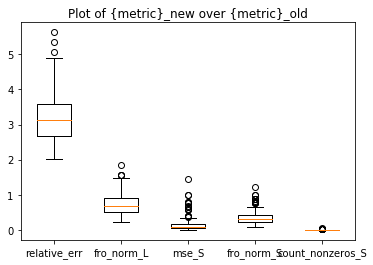

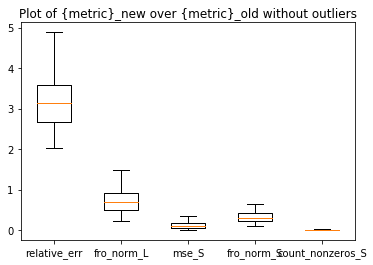

relative_err: 3/120 outliers
fro_norm_L: 4/120 outliers
mse_S: 17/120 outliers
fro_norm_S: 13/120 outliers
count_nonzeros_S: 14/120 outliers


In [87]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [88]:
print("P-values from test of mean with H1: _new/_old < 1")
# print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
relative_err:  1.0
fro_norm_L:  9.630797278923558e-13
mse_S:  7.539432586376243e-67
fro_norm_S:  1.6937060993004706e-59
count_nonzeros_S:  1.0776990338140903e-248


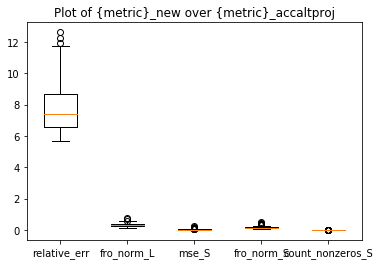

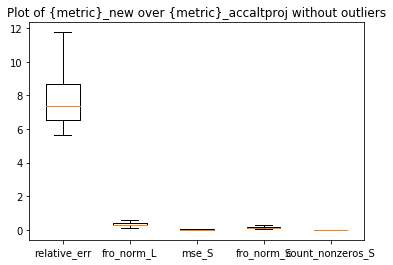

relative_err: 3/120 outliers
fro_norm_L: 3/120 outliers
mse_S: 13/120 outliers
fro_norm_S: 10/120 outliers
count_nonzeros_S: 12/120 outliers


In [89]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [90]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0
fro_norm_L:  8.719638267224518e-92
mse_S:  3.240100147837162e-168
fro_norm_S:  6.631774770088283e-122
count_nonzeros_S:  3.535613229689233e-290


In [91]:
print(np.median(count_nonzeros_S_new), np.mean(count_nonzeros_S_new))
print(np.median(count_nonzeros_S_accaltproj), np.mean(count_nonzeros_S_accaltproj))

0.000696 0.0016562665
0.5636 0.58347106
